In [1]:
%pylab inline
from scipy.integrate import quad

Populating the interactive namespace from numpy and matplotlib


Defining some constants:

In [2]:
beta = 1.
U = 0.1
t = 1.

Generating Matsubarara frequencies for fermions:

In [3]:
N = 100 #corresponds to max frequency
n = np.arange(-N,N)
freq = np.pi/beta *(2*n+1)

Defining two versions of Fouriertransforms

In [4]:
#vals, freq must be arrays of same length, time can be arbitrary
def inv_fourier_naiv(vals, freq, time):
    return 1./ beta * np.sum(np.exp(-1j*time[:,np.newaxis]*freq)*vals,axis=1) #using numpy broadcasting

def inv_fourier(vals,freq,time):
    return - 0.5 + 1./ beta *np.sum(np.exp(-1j*time[:,np.newaxis]*freq)*(vals-1./(1j*freq) ),axis=1)
    

The second version takes use of:
$$G(τ)=-\frac{1}{2} \quad \to \quad G(i ω) =\frac{1}{i ω}$$
Testing these implementiations with known analytic solutions:
$$G(iω) = \frac{1}{iω +a} \quad \to \quad G(τ)=-e^{aτ}n_{FD}(a)$$

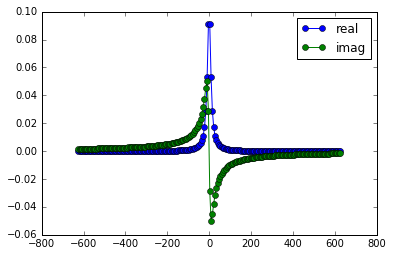

In [5]:
a=10
G_omega = 1. / ( 1j*freq + a )
plot(freq, G_omega.real,"o-",label="real")
plot(freq, G_omega.imag,"o-",label="imag")
legend()

Calculating inverse Fourier transform with two versions:

In [6]:
tau = linspace(0,beta,N)
G_tau_naiv = inv_fourier_naiv(G_omega,freq,tau)
G_tau = inv_fourier(G_omega,freq,tau)

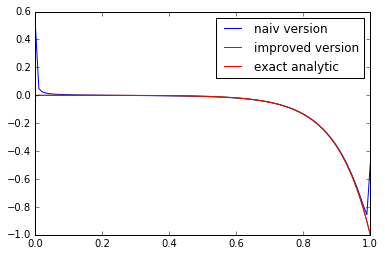

In [7]:
plot(tau,np.real_if_close(G_tau_naiv),label="naiv version")
plot(tau,np.real_if_close(G_tau),label="improved version")
plot(tau, -np.exp(a*tau)/(np.exp(a*beta)+1),label="exact analytic")
legend()

As one can see, the improved version approximates the exact analytic version better.

# Improvements?
There are very fast implementations in Numpy (FFT) O(N Log(N)), our implementations are O(N^2), so we want to use FFT to calculate our Fourier-Transforms.
Not sure if this a good idea, but they are for sure faster than our naiv implementations. Have a look at numpy.fft documentation:

---------------------
## Implementation details

There are many ways to define the DFT, varying in the sign of the
exponent, normalization, etc.  In this implementation, the DFT is defined
as

$$
   A_k =  \sum_{m=0}^{n-1} a_m \exp\left\{-2\pi i{mk \over n}\right\}
   \qquad k = 0,\ldots,n-1. $$

The DFT is in general defined for complex inputs and outputs, and a
single-frequency component at linear frequency :math:`f` is
represented by a complex exponential
$a_m = \exp\{2\pi i\,f m\Delta t\}$, where $\Delta t$
is the sampling interval.

The values in the result follow so-called "standard" order: If ``A =
fft(a, n)``, then ``A[0]`` contains the zero-frequency term (the mean of
the signal), which is always purely real for real inputs. Then ``A[1:n/2]``
contains the positive-frequency terms, and ``A[n/2+1:]`` contains the
negative-frequency terms, in order of decreasingly negative frequency.
For an even number of input points, ``A[n/2]`` represents both positive and
negative Nyquist frequency, and is also purely real for real input.  For
an odd number of input points, ``A[(n-1)/2]`` contains the largest positive
frequency, while ``A[(n+1)/2]`` contains the largest negative frequency.
The routine ``np.fft.fftfreq(n)`` returns an array giving the frequencies
of corresponding elements in the output.  The routine
``np.fft.fftshift(A)`` shifts transforms and their frequencies to put the
zero-frequency components in the middle, and ``np.fft.ifftshift(A)`` undoes
that shift.

When the input `a` is a time-domain signal and ``A = fft(a)``, ``np.abs(A)``
is its amplitude spectrum and ``np.abs(A)**2`` is its power spectrum.
The phase spectrum is obtained by ``np.angle(A)``.

The inverse DFT is defined as

$$
   a_m = \frac{1}{n}\sum_{k=0}^{n-1}A_k\exp\left\{2\pi i{mk\over n}\right\}
   \qquad m = 0,\ldots,n-1.$$

It differs from the forward transform by the sign of the exponential
argument and the default normalization by :math:`1/n`.

----------

In order to make this easier, we change our definitions of Fourier-Transform to fit numpy conventions:

$$G(i ω_n) := \int_0^β dτ G(τ) e^{i ω_n τ}$$

Discretizing:
$$
\begin{align}
G(i ω_n) &\approx \sum_{k=0}^{N-1} \Delta τ \, G(\Delta τ \, k) \exp{\left(i \frac{π (2n+1)k}{N}\right)}\\
          &=\frac{\beta}{N} \sum_{k=o}^{N-1} \left( G(\Delta τ \, k)\exp{\left(i π \frac{k}{N}\right)}  \right)  \exp{\left(i \frac{2 π n k}{N}\right)}
\end{align}$$

The same for the inverse fourier transform, after some calculation:
$$G(τ_k) = \frac{N}{β} e^{-i π \frac{k}{N}}\frac{1}{N}\sum_{ω_n}G(i ω_n) e^{-i 2π n k/N}$$

In [120]:
def matsubara_fft(G_tau):
    N = G_tau.shape[0]
    k = np.arange(N, dtype='float')
    return beta/N*np.fft.fft(G_tau*np.exp(1j*np.pi*k/N))
#numpy orders frequencies differently so one has to convert frequencies
def matsubara_freq(N):
    return np.pi/beta *(-2*(np.fft.fftfreq(N))*N+1)
def matsubara_ifft(G_omega):
    N = G_omega.shape[0]
    k = np.arange(N,dtype='float')
    return N/beta*np.exp(-1j*np.pi*k/N)*np.fft.ifft(G_omega)
#following has to be improved:
def matsubara_ifft_trick(G_omega):
    N = G_omega.shape[0]
    freq = matsubara_freq(N)
    k = np.arange(N,dtype='float')
    return -1/2+N/beta*np.exp(-1j*np.pi*k/N)*np.fft.ifft(G_omega-1./(1j*freq) )


In [160]:
N=100
tau = linspace(0,beta,N)
a=10.
G_tau_exact= -np.exp(a*tau)/(np.exp(a*beta)+1)
freq = matsubara_freq(N)

In [167]:
Gomega = matsubara_fft(G_tau_exact)
Gomega_excact = 1. / ( 1j*freq + a )
G_tau_ifft = np.real_if_close(matsubara_ifft(Gomega))
G_exact_ifft = np.real_if_close(matsubara_ifft(Gomega_excact),tol=0.009)
G_exact_ifft_trick = np.real_if_close(matsubara_ifft_trick(Gomega_excact),tol=0.009)

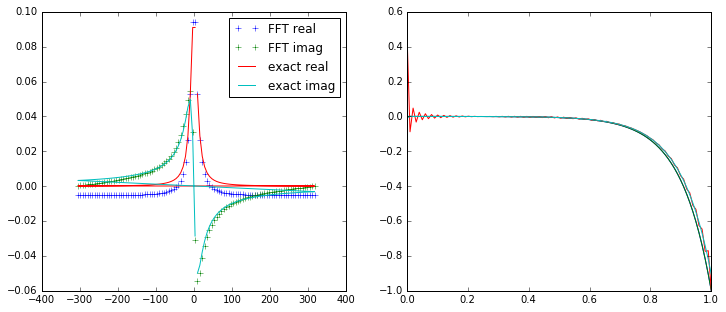

In [168]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,5))
ax1.plot(freq,Gomega.real,"+",label="FFT real")
ax1.plot(freq,Gomega.imag,"+", label="FFT imag")
ax1.plot(freq,Gomega_excact.real,"-",label="exact real")
ax1.plot(freq,Gomega_excact.imag,"-",label="exact imag")
ax1.legend()
ax2.plot(tau, G_tau_exact)
ax2.plot(tau, G_tau_ifft)
ax2.plot(tau, G_exact_ifft)
ax2.plot(tau, G_exact_ifft_trick)